# MÉTHODE DBSCAN
Dans cette étape, nous utilisons strictement la même base de variables que pour la segmentation K-Means, afin de garantir une comparabilité directe des résultats entre les deux approches.

Cette cohérence méthodologique permet :

- d’analyser les mêmes comportements clients sous deux angles complémentaires,

- d’évaluer les différences entre une segmentation partitionnelle (K-Means) et une approche densité-basée (DBSCAN),

- d’identifier plus précisément les clients atypiques qui ne s’intègrent pas naturellement aux clusters moyens.

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [38]:
# DBSCAN_pipeline
# ============================================================
# Chargement df_seg_base exporté
# ============================================================
DATA_PATH = "/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/df_kmeans_clusters.csv"

df_kmeans = pd.read_csv(
    DATA_PATH,
)

print("Dataset DBSCAN chargé :", df_kmeans.shape)
df_kmeans.head()

Dataset DBSCAN chargé : (92754, 8)


,customer_unique_id,recency,frequency,monetary_value,mean_review_score,mean_payment_installments,nb_orders,kmeans_label
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,5.0,8.0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4.0,1.0,1,3
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3.0,8.0,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,4.0,4.0,1,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,5.0,6.0,1,2


## Préparation des features pour DBSCAN
Préparation des variables numériques pour DBSCAN (StandardScaler).

In [39]:
from sklearn.preprocessing import StandardScaler

def prepare_features_for_dbscan(df_kmeans: pd.DataFrame):
    
    feature_cols = [
        "recency",
        "frequency",
        "monetary_value",
        "mean_review_score",
        "mean_payment_installments"
    ]

    X = df_kmeans[feature_cols].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, feature_cols, scaler

# Choix du paramètre EPS (méthode des k-distances)
Courbe des k-distances pour déterminer eps.

In [40]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

def plot_k_distance(X_scaled, k: int = 5):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)

    distances = np.sort(distances[:, k-1])

    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel("Observations triées")
    plt.ylabel("Distance au k-ième voisin")
    plt.title("Méthode des k-distances (choix eps)")
    plt.show()

## Entraînement DBSCAN

In [41]:
# Entraîne DBSCAN et retourne les labels.

def fit_dbscan_model(
    X_scaled,
    eps: float,
    min_samples: int = 10
):   
    dbscan = DBSCAN(
        eps=eps,
        min_samples=min_samples,
        metric="euclidean"
    )

    labels = dbscan.fit_predict(X_scaled)
    return labels

## Application complète DBSCAN

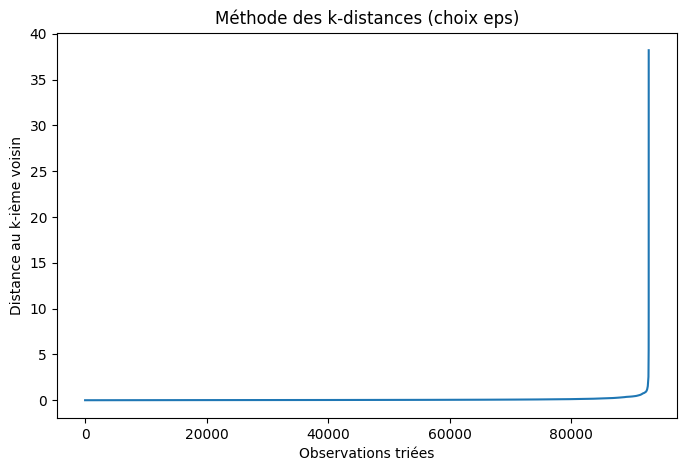

In [42]:
# Préparation des features
X_dbscan, db_features, db_scaler = prepare_features_for_dbscan(df_kmeans)

# Visualisation k-distance
plot_k_distance(X_dbscan, k=5)

# Entraînement (avec eps=0.8)
dbscan_labels = fit_dbscan_model(
    X_dbscan,
    eps=0.8,
    min_samples=100
)

df_kmeans["dbscan_label"] = dbscan_labels

## Analyse des clusters DBSCAN

In [43]:
def profile_dbscan_clusters(df: pd.DataFrame, label_col="dbscan_label"):
    
# Profil moyen des clusters DBSCAN.
    profile = (
        df.groupby(label_col)[
            [
                "recency",
                "frequency",
                "monetary_value",
                "mean_review_score",
                "mean_payment_installments"
            ]
        ]
        .mean()
        .round(2)
    )

    profile["cluster_size"] = df.groupby(label_col).size()
    return profile

profile_db = profile_dbscan_clusters(df_kmeans)
print(profile_db)

              recency  frequency  monetary_value  mean_review_score  \
dbscan_label                                                          
-1             264.53       1.45          887.51               3.46   
 0             237.50       1.00          135.82               4.17   
 1             202.65       2.00          198.81               4.59   

              mean_payment_installments  cluster_size  
dbscan_label                                           
-1                                 6.10          3121  
 0                                 2.80         87941  
 1                                 2.37          1692  


## Détection des clients atypiques (le plus important)

In [44]:
def extract_anomalous_clients(df: pd.DataFrame):
    
# Extraction des clients considérés comme atypiques par DBSCAN.
    
    anomalies = df[df["dbscan_label"] == -1].copy()

    return anomalies.sort_values(
        by="monetary_value",
        ascending=False
    )

anomalies = extract_anomalous_clients(df_kmeans)
print(f"Clients atypiques détectés : {len(anomalies)}")
anomalies.head()

Clients atypiques détectés : 3121


,customer_unique_id,recency,frequency,monetary_value,mean_review_score,mean_payment_installments,nb_orders,kmeans_label,dbscan_label
3704,0a0a92112bd4c708ca5fde585afaa872,334,1,13664.08,1.0,1.0,1,1,-1
79118,da122df9eeddfedc1dc1f5349a1a690c,515,2,7571.63,5.0,10.0,2,2,-1
42894,763c8b1c9c68a0229c42c9fc6f662b93,46,1,7274.88,1.0,1.0,1,1,-1
79937,dc4802a71eae9be1dd28f5d788ceb526,563,1,6929.31,5.0,8.0,1,2,-1
92480,ff4159b92c40ebe40454e3e6a7c35ed6,462,1,6726.66,5.0,1.0,1,2,-1


## Visualisation interactive

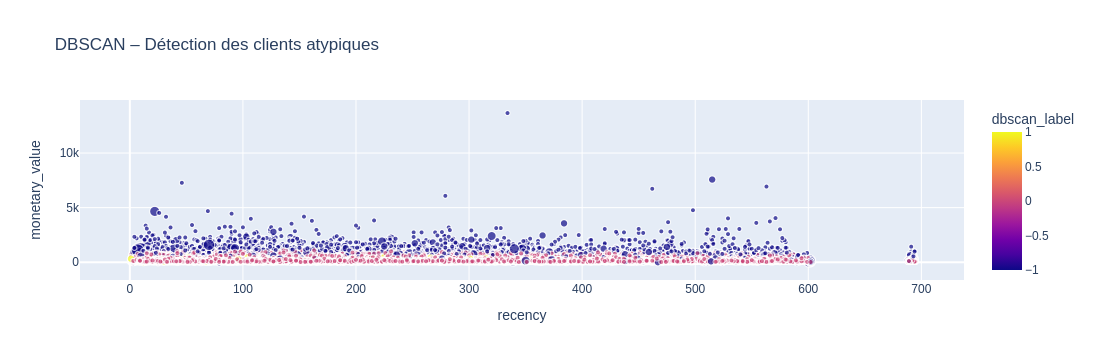

In [45]:
import plotly.express as px

def plot_dbscan_scatter(df):
    fig = px.scatter(
        df,
        x="recency",
        y="monetary_value",
        color="dbscan_label",
        size="frequency",
        title="DBSCAN – Détection des clients atypiques",
        hover_data=[
            "mean_review_score",
            "mean_payment_installments"
        ]
    )
    return fig

fig_dbscan = plot_dbscan_scatter(df_kmeans)
fig_dbscan

## Vue Priorisation Clients
Aide les équipes métiers à prendre des décisions rapides et éclairées en s’appuyant sur les clusters clients- VIP 
- À Risque 
- Standard 
- Atypiques
- VIP

In [46]:
def build_vip_risk_view(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()

    # Flags initiaux
    df["vip_flag"] = False
    df["risk_flag"] = False
    df["atypical_flag"] = False

    # =======================================================
    # VIP 
    # =======================================================
    df.loc[
        (df["recency"] <= df["recency"].quantile(0.25)) &
        (df["frequency"] >= df["frequency"].quantile(0.75)) &
        (df["monetary_value"] >= df["monetary_value"].quantile(0.75)),
        "vip_flag"
    ] = True

    # =======================================================
    # Clients à risque
    # =======================================================
    df.loc[
        (df["recency"] >= df["recency"].quantile(0.75)) &
        (df["frequency"] <= df["frequency"].quantile(0.25)),
        "risk_flag"
    ] = True

    # =======================================================
    # Clients atypiques DBSCAN
    # ========================================================
    if "dbscan_label" in df.columns:
        df.loc[df["dbscan_label"] == -1, "atypical_flag"] = True

    # ==========================================================
    # Typologie finale
    # ==========================================================
    def classify_client(row):
        if row["vip_flag"] and row["atypical_flag"]:
            return "VIP_atypique"
        if row["vip_flag"]:
            return "VIP"
        if row["risk_flag"]:
            return "A_risque"
        if row["atypical_flag"]:
            return "Atypique"
        return "Standard"

    df["client_status"] = df.apply(classify_client, axis=1)

    return df

df_clients_view = build_vip_risk_view(df_kmeans)

df_clients_view["client_status"].value_counts()

client_status
Standard        62335
A_risque        22690
VIP              5297
Atypique         1747
VIP_atypique      685
Name: count, dtype: int64

## Vue synthétique (pilotage business)
Résumé des statuts clients.

In [47]:
def summarize_client_status(df: pd.DataFrame) -> pd.DataFrame:
   
    summary = (
        df.groupby("client_status")
        .agg(
            nb_clients=("customer_unique_id", "count"),
            avg_recency=("recency", "mean"),
            avg_frequency=("frequency", "mean"),
            avg_monetary=("monetary_value", "mean")
        )
        .round(2)
        .sort_values("avg_monetary", ascending=False)
    )
    return summary

summary_status = summarize_client_status(df_clients_view)
print(summary_status)

               nb_clients  avg_recency  avg_frequency  avg_monetary
client_status                                                      
VIP_atypique          685        58.73           1.51       1034.49
Atypique             1747       261.51           1.61        775.13
VIP                  5297        58.41           1.05        313.20
A_risque            22690       451.15           1.00        157.58
Standard            62335       176.65           1.02        124.38


## Exporte les clients atypiques DBSCAN pour analyse CRM.

In [50]:
def export_atypical_clients(
    df: pd.DataFrame,
    output_path: str = "clients_atypiques.csv"
):
    
    cols_to_export = [
        "customer_unique_id",
        "recency",
        "frequency",
        "monetary_value",
        "mean_review_score",
        "mean_payment_installments",
        "client_status",
        "dbscan_label"
    ]

    atypical = df[df["client_status"].isin(["Atypique", "VIP_atypique"])]

    atypical[cols_to_export].sort_values(
        by="monetary_value",
        ascending=False
    ).to_csv(output_path, index=False)

    print(f" Export terminé : {output_path}")

export_atypical_clients(
    df_clients_view,
    output_path="/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/clients_atypiques_actionables.csv"
)

 Export terminé : /home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/clients_atypiques_actionables.csv
